In [1]:
import torch
import os
import mlflow
import numpy as np
import matplotlib as mpl
from ultralytics import YOLO
import ultralytics
import pycocotools.coco
import pycocowriter.coco2yolo
import requests
import sys
from hierarchical_yolo.hierarchical_detection import *
from hierarchical_yolo.deep7_model import *

In [2]:
'''
deep7 categories:

  0: Kalekale
  1: Opakapaka
  2: "Hapu\u02BBupu\u02BBu"
  3: Gindai
  4: Other or Can't Tell
  5: Ehu
  6: Lehi
  7: Onaga
  8: Snapper
  9: Grouper
  10: Object
'''

deep7_hierarchy = {
    0: 8,
    1: 8,
    2: 9,
    3: 8,
    5: 8,
    6: 8,
    7: 8,
    4: 10,
    8: 10,
    9: 10
}

In [3]:
from ultralytics import settings

# View all settings
print(settings)

JSONDict("/home/noaa_brown/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/noaa_brown/datasets",
  "weights_dir": "/home/noaa_brown/hierarchical_yolo/weights",
  "runs_dir": "/home/noaa_brown/hierarchical_yolo/runs",
  "uuid": "2768c477e7938b5779aff75aed83103f60cf5680dbe7372dfa0b27c233b7d105",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}


In [4]:
devices = list(range(torch.cuda.device_count()))
for i in devices:
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


In [5]:
DATA = '../data'
UPLOAD_URL = 'https://storage.googleapis.com/nmfs_odp_hq/nodd_tools/datasets/oceaneyes/annotation_number_balanced_sample/annotations.json'
DOWNLOAD_PATH = os.path.join(DATA, 'download')
COCO_PATH = os.path.join(DOWNLOAD_PATH, 'annotations.json')
YOLO_PATH = os.path.join(DOWNLOAD_PATH, 'yolo_training_data')
IMAGES_PATH = os.path.join(YOLO_PATH, 'annotations', 'images')
os.makedirs(YOLO_PATH, exist_ok=True)
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [6]:
uploaded_coco_file = requests.get(UPLOAD_URL)
with open(COCO_PATH, 'wb') as f:
    f.write(uploaded_coco_file.content)
    coco = pycocotools.coco.COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [7]:
coco.info()

year: 2024
version: 0.1
description: https://www.zooniverse.org/projects/benjamin-dot-richards/oceaneyes/about/research
contributor: None
url: None
date_created: 2025-02-06T20:56:54.886937+00:00


In [8]:
pycocowriter.coco2yolo.coco2yolo(DOWNLOAD_PATH, YOLO_PATH)

Annotations /home/noaa_brown/hierarchical_yolo/data/download/annotations.json: 100%|██████████| 200/200 [00:00<00:00, 934.05it/s] 

COCO data converted successfully.
Results saved to /home/noaa_brown/hierarchical_yolo/notebooks/coco_converted
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
downloaded 0/200 images (t=0.0s)
downloaded 1/200 images (t=0.0s)
downloaded 2/200 images (t=0.0s)
downloaded 3/200 images (t=0.0s)
downloaded 4/200 images (t=0.0s)
downloaded 5/200 images (t=0.0s)
downloaded 6/200 images (t=0.0s)
downloaded 7/200 images (t=0.0s)
downloaded 8/200 images (t=0.0s)
downloaded 9/200 images (t=0.0s)
downloaded 10/200 images (t=0.0s)
downloaded 11/200 images (t=0.0s)
downloaded 12/200 images (t=0.0s)
downloaded 13/200 images (t=0.0s)
downloaded 14/200 images (t=0.0s)
downloaded 15/200 images (t=0.0s)
downloaded 16/200 images (t=0.0s)
downloaded 17/200 images (t=0.0s)
downloaded 18/200 images (t=0.0s)
downloaded 19/200 images (t=0.0s)
downloaded 20/200 images (t=0.0s)
downloaded 21/200 i

In [9]:
# TODO: the yolov8.yaml model file downloaded from Ultralytics needs manual editing for the number of classes
YOLO_YAML = os.path.join(DATA, 'yolov8.yaml')
YOLO_BASE_MODEL = os.path.join(DATA, 'yolov8n.pt')
YOLO_TRAIN_YAML = os.path.join(YOLO_PATH, 'train.yaml')

In [10]:
mlflow.autolog()

In [11]:
model = YOLO(YOLO_YAML).load(YOLO_BASE_MODEL)  # build a new model from scratch

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 319/355 items from pretrained weights


In [12]:
results = model.train(
    data=YOLO_TRAIN_YAML, 
    epochs=5, imgsz=640, 
    device=devices, 
    batch=max(len(devices), 1),
    trainer=Deep7HierarchicalDetectionTrainer
)

New https://pypi.org/project/ultralytics/8.3.106 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.104 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:6 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=detect, mode=train, model=../data/yolov8.yaml, data=../data/download/yolo_training_data/train.yaml, epochs=5, time=None, patience=100, batch=7, imgsz=640, save=True, save_

train: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 0 backgrounds, 1 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


train: WARNING ⚠️ /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/images/20190913_201709_20190913.203153.002.010131.jpg: ignoring corrupt image/label: negative label values [-0.00068681]
train: WARNING ⚠️ /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/images/20190913_201709_20190913.203153.002.010131.jpg: ignoring corrupt image/label: negative label values [-0.00068681]


val: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 0 backgrounds, 1 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to /home/noaa_brown/hierarchical_yolo/runs/detect/train30/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004921875), 63 bias(decay=0.0)
MLflow: logging run_id(8a823c856a78452bb91a1c519cc307f2) to /home/noaa_brown/hierarchical_yolo/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /home/noaa_brown/hierarchical_yolo/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 14 dataloader workers
Logging results to /home/noaa_brown/hierarchical_yolo/runs/detect/train30
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/29 [00:00<?, ?it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.9609, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.9609, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(807, device='cuda:0')
tensor(793, device='cuda:0')
0000: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0001: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0002: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0003: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0004: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0005: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0006: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0007: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0008: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0009: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

        1/5     0.246G      3.239      4.481      1.969         32        640:   7%|▋         | 2/29 [00:01<00:19,  1.37it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.9649, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.9649, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(195, device='cuda:0')
tensor(183, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.5456, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.5456, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(185, device='cuda:0')
tensor(175, device='cuda:0')


        1/5     0.252G      2.931      4.482      2.021         25        640:  14%|█▍        | 4/29 [00:02<00:08,  2.91it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.3860, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.3860, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(163, device='cuda:0')
tensor(151, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.2462, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.2462, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(204, device='cuda:0')
tensor(194, device='cuda:0')


        1/5     0.252G      3.007      4.535      1.923        137        640:  21%|██        | 6/29 [00:02<00:05,  4.22it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.3166, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.3166, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(354, device='cuda:0')
tensor(342, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.7165, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.7165, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(98, device='cuda:0')
tensor(86, device='cuda:0')


        1/5     0.252G      3.053      4.595      1.914         85        640:  28%|██▊       | 8/29 [00:02<00:03,  5.29it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.3830, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.3830, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(419, device='cuda:0')
tensor(409, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.0207, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.0207, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(308, device='cuda:0')
tensor(298, device='cuda:0')


        1/5     0.258G      3.113      4.614      1.886         65        640:  34%|███▍      | 10/29 [00:02<00:03,  5.96it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.7411, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.7411, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(135, device='cuda:0')
tensor(125, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.8085, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.8085, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(184, device='cuda:0')
tensor(172, device='cuda:0')


        1/5      0.26G      3.095      4.623      1.889         31        640:  41%|████▏     | 12/29 [00:03<00:02,  6.25it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.8530, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.8530, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(116, device='cuda:0')
tensor(106, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.7845, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.7845, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(384, device='cuda:0')
tensor(374, device='cuda:0')


        1/5     0.268G      3.051      4.607      1.875         56        640:  48%|████▊     | 14/29 [00:03<00:02,  5.99it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.2708, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.2708, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(307, device='cuda:0')
tensor(297, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.8215, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.8215, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(267, device='cuda:0')
tensor(255, device='cuda:0')


        1/5     0.281G      2.996      4.598      1.862         28        640:  55%|█████▌    | 16/29 [00:03<00:02,  6.31it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.3055, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.3055, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(129, device='cuda:0')
tensor(119, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.4219, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.4219, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(237, device='cuda:0')
tensor(225, device='cuda:0')


        1/5     0.281G      2.985      4.612      1.843         17        640:  62%|██████▏   | 18/29 [00:04<00:01,  6.45it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(9.4738, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.4738, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(121, device='cuda:0')
tensor(111, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.9923, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.9923, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(249, device='cuda:0')
tensor(239, device='cuda:0')


        1/5     0.281G      2.978      4.595        1.8         82        640:  69%|██████▉   | 20/29 [00:04<00:01,  6.62it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.7828, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.7828, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(353, device='cuda:0')
tensor(345, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.5206, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.5206, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(277, device='cuda:0')
tensor(269, device='cuda:0')


        1/5     0.281G      2.941      4.571      1.778         76        640:  76%|███████▌  | 22/29 [00:04<00:01,  6.48it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.8216, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.8216, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(455, device='cuda:0')
tensor(447, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.7748, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.7748, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(261, device='cuda:0')
tensor(253, device='cuda:0')


        1/5     0.281G      2.925      4.542      1.741         55        640:  83%|████████▎ | 24/29 [00:05<00:00,  6.93it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.1230, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.1230, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(177, device='cuda:0')
tensor(167, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.6824, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.6824, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(596, device='cuda:0')
tensor(588, device='cuda:0')


        1/5     0.281G      2.886       4.51      1.711         38        640:  90%|████████▉ | 26/29 [00:05<00:00,  6.70it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.7810, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.7810, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(286, device='cuda:0')
tensor(274, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.1209, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.1209, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(289, device='cuda:0')
tensor(279, device='cuda:0')


        1/5     0.281G       2.84      4.489      1.711          7        640:  97%|█████████▋| 28/29 [00:05<00:00,  6.59it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.7696, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.7696, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(56, device='cuda:0')
tensor(44, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.5032, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.5032, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(641, device='cuda:0')
tensor(631, device='cuda:0')


        1/5     0.281G      2.838      4.481      1.711        115        640: 100%|██████████| 29/29 [00:05<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/100 [00:00<?, ?it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4386, device='cuda:0')
tensor(8.4386, device='cuda:0')
target onehots check
tensor(582, device='cuda:0')
tensor(554, device='cuda:0')
0000: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0001: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0002: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0003: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0004: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0005: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0006: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0007: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0008: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0009: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
0010: 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 4/100 [00:00<00:11,  8.24it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7150, device='cuda:0')
tensor(8.7150, device='cuda:0')
target onehots check
tensor(271, device='cuda:0')
tensor(251, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7705, device='cuda:0')
tensor(8.7705, device='cuda:0')
target onehots check
tensor(95, device='cuda:0')
tensor(69, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5015, device='cuda:0')
tensor(8.5015, device='cuda:0')
target onehots check
tensor(110, device='cuda:0')
tensor(84, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
target onehots che

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 10/100 [00:00<00:05, 16.21it/s]

torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5830, device='cuda:0')
tensor(8.5830, device='cuda:0')
target onehots check
tensor(61, device='cuda:0')
tensor(35, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.2073, device='cuda:0')
tensor(9.2073, device='cuda:0')
target onehots check
tensor(67, device='cuda:0')
tensor(39, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.2481, device='cuda:0')
tensor(9.2481, device='cuda:0')
target onehots check
tensor(30, device='cuda:0')
tensor(6, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.2155, device='cuda:0')
tensor(9.2155, device='cuda:0')
target onehots check
tensor(77, d

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 16/100 [00:01<00:04, 20.66it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
target onehots check
tensor(90, device='cuda:0')
tensor(64, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.1993, device='cuda:0')
tensor(9.1993, device='cuda:0')
target onehots check
tensor(52, device='cuda:0')
tensor(26, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.0545, device='cuda:0')
tensor(9.0545, device='cuda:0')
target onehots check
tensor(33, device='cuda:0')
tensor(5, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6326, device='cuda:0')
tensor(8.6326, device='cuda:0')
target onehots check
t

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 22/100 [00:01<00:03, 22.96it/s]

class loss
tensor(8.8514, device='cuda:0')
tensor(8.8514, device='cuda:0')
target onehots check
tensor(159, device='cuda:0')
tensor(135, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6681, device='cuda:0')
tensor(8.6681, device='cuda:0')
target onehots check
tensor(173, device='cuda:0')
tensor(149, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5666, device='cuda:0')
tensor(8.5666, device='cuda:0')
target onehots check
tensor(205, device='cuda:0')
tensor(181, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.0808, device='cuda:0')
tensor(9.0808, device='cuda:0')
target onehots check
tensor(296, device='cuda:0')
tensor(272, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 28/100 [00:01<00:03, 23.91it/s]

tensor(228, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6381, device='cuda:0')
tensor(8.6381, device='cuda:0')
target onehots check
tensor(298, device='cuda:0')
tensor(276, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5846, device='cuda:0')
tensor(8.5846, device='cuda:0')
target onehots check
tensor(162, device='cuda:0')
tensor(140, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3972, device='cuda:0')
tensor(8.3972, device='cuda:0')
target onehots check
tensor(115, device='cuda:0')
tensor(91, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.2566, device='cuda:0')
tensor(8.2566, devi

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  34%|███▍      | 34/100 [00:01<00:02, 24.27it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.1121, device='cuda:0')
tensor(9.1121, device='cuda:0')
target onehots check
tensor(232, device='cuda:0')
tensor(210, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.1695, device='cuda:0')
tensor(9.1695, device='cuda:0')
target onehots check
tensor(296, device='cuda:0')
tensor(270, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.2170, device='cuda:0')
tensor(9.2170, device='cuda:0')
target onehots check
tensor(153, device='cuda:0')
tensor(129, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.1984, device='cuda:0')
tensor(9.1984, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 40/100 [00:02<00:02, 24.86it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6113, device='cuda:0')
tensor(8.6113, device='cuda:0')
target onehots check
tensor(320, device='cuda:0')
tensor(302, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6124, device='cuda:0')
tensor(8.6124, device='cuda:0')
target onehots check
tensor(231, device='cuda:0')
tensor(211, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.9282, device='cuda:0')
tensor(8.9282, device='cuda:0')
target onehots check
tensor(127, device='cuda:0')
tensor(99, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6700, device='cuda:0')
tensor(8.6700, device='cuda:0')
target onehots c

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 46/100 [00:02<00:02, 25.03it/s]

tensor(8.9478, device='cuda:0')
target onehots check
tensor(68, device='cuda:0')
tensor(42, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.0194, device='cuda:0')
tensor(9.0194, device='cuda:0')
target onehots check
tensor(50, device='cuda:0')
tensor(24, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.8517, device='cuda:0')
tensor(8.8517, device='cuda:0')
target onehots check
tensor(128, device='cuda:0')
tensor(102, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6073, device='cuda:0')
tensor(8.6073, device='cuda:0')
target onehots check
tensor(672, device='cuda:0')
tensor(648, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Si

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 52/100 [00:02<00:01, 25.36it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5971, device='cuda:0')
tensor(8.5971, device='cuda:0')
target onehots check
tensor(403, device='cuda:0')
tensor(377, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7280, device='cuda:0')
tensor(8.7280, device='cuda:0')
target onehots check
tensor(512, device='cuda:0')
tensor(486, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7290, device='cuda:0')
tensor(8.7290, device='cuda:0')
target onehots check
tensor(478, device='cuda:0')
tensor(454, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7062, device='cuda:0')
tensor(8.7062, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 58/100 [00:02<00:01, 24.86it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4702, device='cuda:0')
tensor(8.4702, device='cuda:0')
target onehots check
tensor(687, device='cuda:0')
tensor(665, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6167, device='cuda:0')
tensor(8.6167, device='cuda:0')
target onehots check
tensor(740, device='cuda:0')
tensor(716, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5715, device='cuda:0')
tensor(8.5715, device='cuda:0')
target onehots check
tensor(827, device='cuda:0')
tensor(803, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4334, device='cuda:0')
tensor(8.4334, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 64/100 [00:02<00:01, 24.80it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5788, device='cuda:0')
tensor(8.5788, device='cuda:0')
target onehots check
tensor(752, device='cuda:0')
tensor(728, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5034, device='cuda:0')
tensor(8.5034, device='cuda:0')
target onehots check
tensor(978, device='cuda:0')
tensor(954, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3339, device='cuda:0')
tensor(8.3339, device='cuda:0')
target onehots check
tensor(839, device='cuda:0')
tensor(813, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4221, device='cuda:0')
tensor(8.4221, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 70/100 [00:03<00:01, 24.72it/s]

tensor(8.4707, device='cuda:0')
tensor(8.4707, device='cuda:0')
target onehots check
tensor(703, device='cuda:0')
tensor(679, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3805, device='cuda:0')
tensor(8.3805, device='cuda:0')
target onehots check
tensor(746, device='cuda:0')
tensor(722, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4219, device='cuda:0')
tensor(8.4219, device='cuda:0')
target onehots check
tensor(807, device='cuda:0')
tensor(783, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5910, device='cuda:0')
tensor(8.5910, device='cuda:0')
target onehots check
tensor(927, device='cuda:0')
tensor(903, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 76/100 [00:03<00:01, 23.76it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3670, device='cuda:0')
tensor(8.3670, device='cuda:0')
target onehots check
tensor(917, device='cuda:0')
tensor(889, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3137, device='cuda:0')
tensor(8.3137, device='cuda:0')
target onehots check
tensor(737, device='cuda:0')
tensor(709, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.2742, device='cuda:0')
tensor(8.2742, device='cuda:0')
target onehots check
tensor(689, device='cuda:0')
tensor(665, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5178, device='cuda:0')
tensor(8.5178, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 82/100 [00:03<00:00, 24.23it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6628, device='cuda:0')
tensor(8.6628, device='cuda:0')
target onehots check
tensor(560, device='cuda:0')
tensor(536, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5829, device='cuda:0')
tensor(8.5829, device='cuda:0')
target onehots check
tensor(713, device='cuda:0')
tensor(689, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6146, device='cuda:0')
tensor(8.6146, device='cuda:0')
target onehots check
tensor(749, device='cuda:0')
tensor(725, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6795, device='cuda:0')
tensor(8.6795, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  88%|████████▊ | 88/100 [00:03<00:00, 24.33it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7049, device='cuda:0')
tensor(8.7049, device='cuda:0')
target onehots check
tensor(538, device='cuda:0')
tensor(512, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5888, device='cuda:0')
tensor(8.5888, device='cuda:0')
target onehots check
tensor(983, device='cuda:0')
tensor(959, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.5506, device='cuda:0')
tensor(8.5506, device='cuda:0')
target onehots check
tensor(770, device='cuda:0')
tensor(742, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6626, device='cuda:0')
tensor(8.6626, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 94/100 [00:04<00:00, 24.30it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4624, device='cuda:0')
tensor(8.4624, device='cuda:0')
target onehots check
tensor(499, device='cuda:0')
tensor(475, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7478, device='cuda:0')
tensor(8.7478, device='cuda:0')
target onehots check
tensor(510, device='cuda:0')
tensor(486, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4891, device='cuda:0')
tensor(8.4891, device='cuda:0')
target onehots check
tensor(352, device='cuda:0')
tensor(328, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.9501, device='cuda:0')
tensor(8.9501, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:04<00:00, 22.24it/s]


pred shape
torch.Size([1, 7056, 8])
target shape
torch.Size([1, 7056, 8])
bboxes shape
torch.Size([1, 7056, 4])
class loss
tensor(9.0361, device='cuda:0')
tensor(9.0361, device='cuda:0')
target onehots check
tensor(71, device='cuda:0')
tensor(59, device='cuda:0')
                   all        199       6757    0.00157    0.00689     0.0023    0.00114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.1792, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.1792, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(376, device='cuda:0')
tensor(368, device='cuda:0')


        2/5     0.297G      2.433       4.09      1.689         49        640:   3%|▎         | 1/29 [00:00<00:04,  6.22it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.6873, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.6873, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(255, device='cuda:0')
tensor(247, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.7556, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.7556, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(172, device='cuda:0')
tensor(160, device='cuda:0')


        2/5     0.297G      2.389      3.937      1.506         20        640:  10%|█         | 3/29 [00:00<00:04,  6.40it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.0705, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.0705, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(156, device='cuda:0')
tensor(146, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.3517, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.3517, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(60, device='cuda:0')
tensor(50, device='cuda:0')


        2/5     0.299G      2.588      4.004      1.423         13        640:  17%|█▋        | 5/29 [00:00<00:03,  6.82it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.0628, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.0628, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(246, device='cuda:0')
tensor(238, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.2258, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.2258, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(176, device='cuda:0')
tensor(168, device='cuda:0')


        2/5     0.299G      2.616      3.952      1.403         35        640:  24%|██▍       | 7/29 [00:01<00:03,  6.75it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.5728, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.5728, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(495, device='cuda:0')
tensor(483, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.9277, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.9277, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(294, device='cuda:0')
tensor(280, device='cuda:0')


        2/5     0.301G      2.563      3.935      1.479         31        640:  31%|███       | 9/29 [00:01<00:02,  6.95it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.6997, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.6997, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(489, device='cuda:0')
tensor(477, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.5396, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.5396, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(177, device='cuda:0')
tensor(167, device='cuda:0')


        2/5     0.301G      2.518      3.867      1.488         18        640:  38%|███▊      | 11/29 [00:01<00:02,  6.82it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.9938, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.9938, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(176, device='cuda:0')
tensor(168, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.1588, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.1588, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(107, device='cuda:0')
tensor(97, device='cuda:0')


        2/5     0.301G       2.49      3.855      1.474         15        640:  45%|████▍     | 13/29 [00:01<00:02,  7.19it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.2136, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.2136, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(495, device='cuda:0')
tensor(483, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.7015, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.7015, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(105, device='cuda:0')
tensor(95, device='cuda:0')


        2/5     0.301G      2.456      3.838       1.46         17        640:  52%|█████▏    | 15/29 [00:02<00:02,  6.92it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.9376, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.9376, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(525, device='cuda:0')
tensor(513, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.1486, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.1486, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(180, device='cuda:0')
tensor(170, device='cuda:0')


        2/5     0.301G      2.452      3.801      1.452         25        640:  59%|█████▊    | 17/29 [00:02<00:01,  7.16it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.5874, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.5874, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(467, device='cuda:0')
tensor(457, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.5023, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.5023, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(227, device='cuda:0')
tensor(217, device='cuda:0')


        2/5     0.301G      2.461      3.745      1.436         70        640:  66%|██████▌   | 19/29 [00:02<00:01,  6.99it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.7945, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.7945, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(482, device='cuda:0')
tensor(474, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9906, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9906, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(177, device='cuda:0')
tensor(165, device='cuda:0')


        2/5     0.301G      2.435      3.669      1.422         36        640:  72%|███████▏  | 21/29 [00:03<00:01,  7.17it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.9248, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.9248, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(91, device='cuda:0')
tensor(79, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.6679, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.6679, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(294, device='cuda:0')
tensor(284, device='cuda:0')


        2/5     0.301G      2.449      3.646      1.404         54        640:  79%|███████▉  | 23/29 [00:03<00:00,  7.29it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.3764, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.3764, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(391, device='cuda:0')
tensor(385, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.1769, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.1769, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(195, device='cuda:0')
tensor(187, device='cuda:0')


        2/5     0.301G       2.44      3.665      1.394         38        640:  86%|████████▌ | 25/29 [00:03<00:00,  6.99it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.3365, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.3365, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(411, device='cuda:0')
tensor(401, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.0629, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.0629, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(82, device='cuda:0')
tensor(74, device='cuda:0')


        2/5     0.301G      2.474      3.642      1.389         42        640:  93%|█████████▎| 27/29 [00:03<00:00,  7.17it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.3118, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.3118, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(111, device='cuda:0')
tensor(101, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.6044, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.6044, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(756, device='cuda:0')
tensor(744, device='cuda:0')


        2/5     0.301G      2.476      3.648      1.391        118        640: 100%|██████████| 29/29 [00:04<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/100 [00:00<?, ?it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.1290, device='cuda:0')
tensor(7.1290, device='cuda:0')
target onehots check
tensor(588, device='cuda:0')
tensor(560, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.2157, device='cuda:0')
tensor(7.2157, device='cuda:0')
target onehots check
tensor(267, device='cuda:0')
tensor(239, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6151, device='cuda:0')
tensor(8.6151, device='cuda:0')
target onehots check
tensor(77, device='cuda:0')
tensor(53, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.8940, device='cuda:0')
tensor(7.8940, device='cuda:0')
target onehots ch

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 5/100 [00:00<00:04, 20.59it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.8757, device='cuda:0')
tensor(7.8757, device='cuda:0')
target onehots check
tensor(98, device='cuda:0')
tensor(72, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.9166, device='cuda:0')
tensor(7.9166, device='cuda:0')
target onehots check
tensor(118, device='cuda:0')
tensor(92, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.1287, device='cuda:0')
tensor(9.1287, device='cuda:0')
target onehots check
tensor(124, device='cuda:0')
tensor(98, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.1903, device='cuda:0')
tensor(7.1903, device='cuda:0')
target onehots chec

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 11/100 [00:00<00:04, 21.50it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3394, device='cuda:0')
tensor(8.3394, device='cuda:0')
target onehots check
tensor(66, device='cuda:0')
tensor(38, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.8996, device='cuda:0')
tensor(8.8996, device='cuda:0')
target onehots check
tensor(36, device='cuda:0')
tensor(12, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.1161, device='cuda:0')
tensor(8.1161, device='cuda:0')
target onehots check
tensor(85, device='cuda:0')
tensor(61, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(9.1039, device='cuda:0')
tensor(9.1039, device='cuda:0')
target onehots check


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 17/100 [00:00<00:03, 21.98it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7807, device='cuda:0')
tensor(8.7807, device='cuda:0')
target onehots check
tensor(89, device='cuda:0')
tensor(63, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.1175, device='cuda:0')
tensor(8.1175, device='cuda:0')
target onehots check
tensor(56, device='cuda:0')
tensor(30, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.4353, device='cuda:0')
tensor(7.4353, device='cuda:0')
target onehots check
tensor(35, device='cuda:0')
tensor(7, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.2799, device='cuda:0')
tensor(7.2799, device='cuda:0')
target onehots check
t

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 23/100 [00:01<00:03, 23.39it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3069, device='cuda:0')
tensor(8.3069, device='cuda:0')
target onehots check
tensor(164, device='cuda:0')
tensor(140, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.1045, device='cuda:0')
tensor(8.1045, device='cuda:0')
target onehots check
tensor(172, device='cuda:0')
tensor(148, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.8903, device='cuda:0')
tensor(7.8903, device='cuda:0')
target onehots check
tensor(213, device='cuda:0')
tensor(189, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.0993, device='cuda:0')
tensor(8.0993, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▉       | 29/100 [00:01<00:02, 23.83it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.2536, device='cuda:0')
tensor(7.2536, device='cuda:0')
target onehots check
tensor(188, device='cuda:0')
tensor(162, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4832, device='cuda:0')
tensor(8.4832, device='cuda:0')
target onehots check
tensor(227, device='cuda:0')
tensor(205, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.4464, device='cuda:0')
tensor(8.4464, device='cuda:0')
target onehots check
tensor(299, device='cuda:0')
tensor(273, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.7560, device='cuda:0')
tensor(8.7560, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▌      | 35/100 [00:01<00:02, 24.59it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.5521, device='cuda:0')
tensor(7.5521, device='cuda:0')
target onehots check
tensor(149, device='cuda:0')
tensor(125, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.1244, device='cuda:0')
tensor(7.1244, device='cuda:0')
target onehots check
tensor(177, device='cuda:0')
tensor(151, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.0744, device='cuda:0')
tensor(7.0744, device='cuda:0')
target onehots check
tensor(262, device='cuda:0')
tensor(238, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.1424, device='cuda:0')
tensor(7.1424, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████      | 41/100 [00:01<00:02, 24.69it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.5330, device='cuda:0')
tensor(7.5330, device='cuda:0')
target onehots check
tensor(223, device='cuda:0')
tensor(201, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.4305, device='cuda:0')
tensor(7.4305, device='cuda:0')
target onehots check
tensor(327, device='cuda:0')
tensor(311, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.2043, device='cuda:0')
tensor(7.2043, device='cuda:0')
target onehots check
tensor(234, device='cuda:0')
tensor(214, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6320, device='cuda:0')
tensor(6.6320, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 47/100 [00:01<00:02, 25.18it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.8256, device='cuda:0')
tensor(7.8256, device='cuda:0')
target onehots check
tensor(73, device='cuda:0')
tensor(47, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.3940, device='cuda:0')
tensor(7.3940, device='cuda:0')
target onehots check
tensor(52, device='cuda:0')
tensor(26, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4739, device='cuda:0')
tensor(6.4739, device='cuda:0')
target onehots check
tensor(134, device='cuda:0')
tensor(108, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6577, device='cuda:0')
tensor(6.6577, device='cuda:0')
target onehots chec

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 53/100 [00:02<00:01, 25.44it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.5117, device='cuda:0')
tensor(6.5117, device='cuda:0')
target onehots check
tensor(405, device='cuda:0')
tensor(379, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.8394, device='cuda:0')
tensor(6.8394, device='cuda:0')
target onehots check
tensor(514, device='cuda:0')
tensor(488, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7896, device='cuda:0')
tensor(6.7896, device='cuda:0')
target onehots check
tensor(497, device='cuda:0')
tensor(473, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6399, device='cuda:0')
tensor(6.6399, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  59%|█████▉    | 59/100 [00:02<00:01, 24.99it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6647, device='cuda:0')
tensor(6.6647, device='cuda:0')
target onehots check
tensor(703, device='cuda:0')
tensor(681, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.5079, device='cuda:0')
tensor(6.5079, device='cuda:0')
target onehots check
tensor(758, device='cuda:0')
tensor(734, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6464, device='cuda:0')
tensor(6.6464, device='cuda:0')
target onehots check
tensor(839, device='cuda:0')
tensor(815, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.3844, device='cuda:0')
tensor(6.3844, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 65/100 [00:02<00:01, 24.43it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6249, device='cuda:0')
tensor(6.6249, device='cuda:0')
target onehots check
tensor(758, device='cuda:0')
tensor(734, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.9302, device='cuda:0')
tensor(6.9302, device='cuda:0')
target onehots check
tensor(991, device='cuda:0')
tensor(967, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.3649, device='cuda:0')
tensor(6.3649, device='cuda:0')
target onehots check
tensor(840, device='cuda:0')
tensor(814, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6816, device='cuda:0')
tensor(6.6816, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████   | 71/100 [00:02<00:01, 24.35it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7395, device='cuda:0')
tensor(6.7395, device='cuda:0')
target onehots check
tensor(703, device='cuda:0')
tensor(679, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.8338, device='cuda:0')
tensor(6.8338, device='cuda:0')
target onehots check
tensor(741, device='cuda:0')
tensor(717, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.8321, device='cuda:0')
tensor(6.8321, device='cuda:0')
target onehots check
tensor(809, device='cuda:0')
tensor(785, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.8739, device='cuda:0')
tensor(6.8739, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 77/100 [00:03<00:00, 24.02it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7831, device='cuda:0')
tensor(6.7831, device='cuda:0')
target onehots check
tensor(906, device='cuda:0')
tensor(882, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7204, device='cuda:0')
tensor(6.7204, device='cuda:0')
target onehots check
tensor(1055, device='cuda:0')
tensor(1031, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7369, device='cuda:0')
tensor(6.7369, device='cuda:0')
target onehots check
tensor(729, device='cuda:0')
tensor(705, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6425, device='cuda:0')
tensor(6.6425, device='cuda:0')
target onehot

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 83/100 [00:03<00:00, 24.08it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.9094, device='cuda:0')
tensor(6.9094, device='cuda:0')
target onehots check
tensor(569, device='cuda:0')
tensor(545, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.5742, device='cuda:0')
tensor(6.5742, device='cuda:0')
target onehots check
tensor(731, device='cuda:0')
tensor(707, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7737, device='cuda:0')
tensor(6.7737, device='cuda:0')
target onehots check
tensor(763, device='cuda:0')
tensor(739, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7533, device='cuda:0')
tensor(6.7533, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 89/100 [00:03<00:00, 24.08it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6369, device='cuda:0')
tensor(6.6369, device='cuda:0')
target onehots check
tensor(540, device='cuda:0')
tensor(514, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.9142, device='cuda:0')
tensor(6.9142, device='cuda:0')
target onehots check
tensor(996, device='cuda:0')
tensor(972, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7901, device='cuda:0')
tensor(6.7901, device='cuda:0')
target onehots check
tensor(782, device='cuda:0')
tensor(754, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.9128, device='cuda:0')
tensor(6.9128, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 95/100 [00:03<00:00, 23.96it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4096, device='cuda:0')
tensor(6.4096, device='cuda:0')
target onehots check
tensor(514, device='cuda:0')
tensor(490, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7511, device='cuda:0')
tensor(6.7511, device='cuda:0')
target onehots check
tensor(519, device='cuda:0')
tensor(495, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4427, device='cuda:0')
tensor(6.4427, device='cuda:0')
target onehots check
tensor(357, device='cuda:0')
tensor(333, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.8057, device='cuda:0')
tensor(8.8057, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:04<00:00, 24.05it/s]


pred shape
torch.Size([1, 7056, 8])
target shape
torch.Size([1, 7056, 8])
bboxes shape
torch.Size([1, 7056, 4])
class loss
tensor(8.9207, device='cuda:0')
tensor(8.9207, device='cuda:0')
target onehots check
tensor(71, device='cuda:0')
tensor(59, device='cuda:0')
                   all        199       6757     0.0256      0.121     0.0408     0.0183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3259, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3259, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(240, device='cuda:0')
tensor(228, device='cuda:0')


        3/5     0.318G      2.227       2.57      1.414         29        640:   7%|▋         | 2/29 [00:00<00:04,  6.23it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9544, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9544, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(100, device='cuda:0')
tensor(88, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2911, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2911, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(226, device='cuda:0')
tensor(214, device='cuda:0')


        3/5     0.318G      2.346       2.66      1.474         16        640:  14%|█▍        | 4/29 [00:00<00:03,  7.24it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7125, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7125, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(151, device='cuda:0')
tensor(137, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7173, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7173, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(281, device='cuda:0')
tensor(267, device='cuda:0')


        3/5     0.318G       2.33      2.782      1.501         56        640:  21%|██        | 6/29 [00:00<00:03,  7.31it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.3781, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.3781, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(425, device='cuda:0')
tensor(413, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7366, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7366, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(305, device='cuda:0')
tensor(295, device='cuda:0')


        3/5     0.318G      2.253      2.803      1.446         41        640:  28%|██▊       | 8/29 [00:01<00:03,  6.98it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7249, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7249, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(207, device='cuda:0')
tensor(199, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7031, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7031, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(516, device='cuda:0')
tensor(506, device='cuda:0')


        3/5     0.318G      2.261        2.8      1.404         73        640:  34%|███▍      | 10/29 [00:01<00:02,  7.07it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.4580, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.4580, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(433, device='cuda:0')
tensor(421, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.0562, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.0562, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(124, device='cuda:0')
tensor(116, device='cuda:0')


        3/5     0.318G      2.248      2.843      1.415         11        640:  41%|████▏     | 12/29 [00:01<00:02,  7.06it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.1718, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.1718, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(100, device='cuda:0')
tensor(88, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7030, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7030, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(489, device='cuda:0')
tensor(477, device='cuda:0')


        3/5     0.318G      2.235      2.848      1.381         80        640:  48%|████▊     | 14/29 [00:02<00:02,  6.52it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.8246, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.8246, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(369, device='cuda:0')
tensor(357, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.0807, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.0807, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(612, device='cuda:0')
tensor(602, device='cuda:0')


        3/5     0.318G      2.242      2.835      1.369         30        640:  55%|█████▌    | 16/29 [00:02<00:01,  6.91it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.8972, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.8972, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(200, device='cuda:0')
tensor(188, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.0521, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.0521, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(152, device='cuda:0')
tensor(142, device='cuda:0')


        3/5     0.318G       2.24      2.796      1.356         49        640:  62%|██████▏   | 18/29 [00:02<00:01,  7.27it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.8614, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.8614, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(194, device='cuda:0')
tensor(182, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.7243, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.7243, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(272, device='cuda:0')
tensor(260, device='cuda:0')


        3/5     0.318G      2.224      2.758      1.349         24        640:  69%|██████▉   | 20/29 [00:02<00:01,  7.09it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9367, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9367, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(216, device='cuda:0')
tensor(204, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.9194, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.9194, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(249, device='cuda:0')
tensor(241, device='cuda:0')


        3/5     0.318G      2.237      2.774      1.347         89        640:  76%|███████▌  | 22/29 [00:03<00:01,  6.84it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.8047, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.8047, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(412, device='cuda:0')
tensor(404, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.2349, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.2349, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(512, device='cuda:0')
tensor(502, device='cuda:0')


        3/5     0.318G      2.247      2.798      1.346         81        640:  83%|████████▎ | 24/29 [00:03<00:00,  6.93it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.0350, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.0350, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(543, device='cuda:0')
tensor(531, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3515, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3515, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(451, device='cuda:0')
tensor(439, device='cuda:0')


        3/5     0.318G      2.257      2.809       1.35        105        640:  90%|████████▉ | 26/29 [00:03<00:00,  6.97it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.4209, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.4209, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(689, device='cuda:0')
tensor(677, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3259, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3259, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(286, device='cuda:0')
tensor(274, device='cuda:0')


        3/5     0.318G      2.255      2.812      1.345         48        640:  97%|█████████▋| 28/29 [00:04<00:00,  7.13it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.0898, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.0898, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(211, device='cuda:0')
tensor(199, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7124, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7124, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(335, device='cuda:0')
tensor(323, device='cuda:0')


        3/5     0.318G      2.267      2.814      1.348         44        640: 100%|██████████| 29/29 [00:04<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 2/100 [00:00<00:04, 19.70it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.5974, device='cuda:0')
tensor(5.5974, device='cuda:0')
target onehots check
tensor(580, device='cuda:0')
tensor(552, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.7364, device='cuda:0')
tensor(5.7364, device='cuda:0')
target onehots check
tensor(269, device='cuda:0')
tensor(241, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.5065, device='cuda:0')
tensor(7.5065, device='cuda:0')
target onehots check
tensor(75, device='cuda:0')
tensor(51, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6730, device='cuda:0')
tensor(6.6730, device='cuda:0')
target onehots ch

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 8/100 [00:00<00:04, 21.78it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4968, device='cuda:0')
tensor(6.4968, device='cuda:0')
target onehots check
tensor(96, device='cuda:0')
tensor(70, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7229, device='cuda:0')
tensor(6.7229, device='cuda:0')
target onehots check
tensor(111, device='cuda:0')
tensor(85, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.1518, device='cuda:0')
tensor(8.1518, device='cuda:0')
target onehots check
tensor(118, device='cuda:0')
tensor(92, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.5701, device='cuda:0')
tensor(5.5701, device='cuda:0')
target onehots chec

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 14/100 [00:00<00:03, 21.98it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.8867, device='cuda:0')
tensor(7.8867, device='cuda:0')
target onehots check
tensor(103, device='cuda:0')
tensor(77, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.1214, device='cuda:0')
tensor(6.1214, device='cuda:0')
target onehots check
tensor(59, device='cuda:0')
tensor(33, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6422, device='cuda:0')
tensor(6.6422, device='cuda:0')
target onehots check
tensor(33, device='cuda:0')
tensor(5, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4076, device='cuda:0')
tensor(6.4076, device='cuda:0')
target onehots check


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 20/100 [00:00<00:03, 23.54it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6985, device='cuda:0')
tensor(6.6985, device='cuda:0')
target onehots check
tensor(173, device='cuda:0')
tensor(149, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.5061, device='cuda:0')
tensor(6.5061, device='cuda:0')
target onehots check
tensor(213, device='cuda:0')
tensor(189, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7413, device='cuda:0')
tensor(6.7413, device='cuda:0')
target onehots check
tensor(299, device='cuda:0')
tensor(275, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.1628, device='cuda:0')
tensor(7.1628, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▌       | 26/100 [00:01<00:03, 23.80it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.4581, device='cuda:0')
tensor(7.4581, device='cuda:0')
target onehots check
tensor(302, device='cuda:0')
tensor(280, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.9193, device='cuda:0')
tensor(6.9193, device='cuda:0')
target onehots check
tensor(165, device='cuda:0')
tensor(143, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.4418, device='cuda:0')
tensor(7.4418, device='cuda:0')
target onehots check
tensor(116, device='cuda:0')
tensor(92, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.5697, device='cuda:0')
tensor(6.5697, device='cuda:0')
target onehots c

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 32/100 [00:01<00:02, 24.23it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7835, device='cuda:0')
tensor(6.7835, device='cuda:0')
target onehots check
tensor(231, device='cuda:0')
tensor(211, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.6655, device='cuda:0')
tensor(6.6655, device='cuda:0')
target onehots check
tensor(310, device='cuda:0')
tensor(284, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.0698, device='cuda:0')
tensor(7.0698, device='cuda:0')
target onehots check
tensor(163, device='cuda:0')
tensor(139, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.8739, device='cuda:0')
tensor(6.8739, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 38/100 [00:01<00:02, 24.44it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.1791, device='cuda:0')
tensor(6.1791, device='cuda:0')
target onehots check
tensor(150, device='cuda:0')
tensor(126, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.8172, device='cuda:0')
tensor(5.8172, device='cuda:0')
target onehots check
tensor(176, device='cuda:0')
tensor(150, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0655, device='cuda:0')
tensor(5.0655, device='cuda:0')
target onehots check
tensor(262, device='cuda:0')
tensor(238, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.3444, device='cuda:0')
tensor(5.3444, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 44/100 [00:01<00:02, 24.42it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.0100, device='cuda:0')
tensor(6.0100, device='cuda:0')
target onehots check
tensor(225, device='cuda:0')
tensor(203, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.8643, device='cuda:0')
tensor(5.8643, device='cuda:0')
target onehots check
tensor(329, device='cuda:0')
tensor(313, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.6290, device='cuda:0')
tensor(5.6290, device='cuda:0')
target onehots check
tensor(238, device='cuda:0')
tensor(218, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0695, device='cuda:0')
tensor(5.0695, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 50/100 [00:02<00:02, 24.86it/s]

tensor(4.6850, device='cuda:0')
tensor(4.6850, device='cuda:0')
target onehots check
tensor(258, device='cuda:0')
tensor(234, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4063, device='cuda:0')
tensor(4.4063, device='cuda:0')
target onehots check
tensor(453, device='cuda:0')
tensor(429, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9684, device='cuda:0')
tensor(4.9684, device='cuda:0')
target onehots check
tensor(404, device='cuda:0')
tensor(378, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9258, device='cuda:0')
tensor(4.9258, device='cuda:0')
target onehots check
tensor(523, device='cuda:0')
tensor(497, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 56/100 [00:02<00:01, 24.14it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.7045, device='cuda:0')
tensor(4.7045, device='cuda:0')
target onehots check
tensor(593, device='cuda:0')
tensor(567, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9995, device='cuda:0')
tensor(4.9995, device='cuda:0')
target onehots check
tensor(836, device='cuda:0')
tensor(812, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0299, device='cuda:0')
tensor(5.0299, device='cuda:0')
target onehots check
tensor(698, device='cuda:0')
tensor(676, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.8911, device='cuda:0')
tensor(4.8911, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 62/100 [00:02<00:01, 23.77it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.6776, device='cuda:0')
tensor(4.6776, device='cuda:0')
target onehots check
tensor(745, device='cuda:0')
tensor(719, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1172, device='cuda:0')
tensor(5.1172, device='cuda:0')
target onehots check
tensor(792, device='cuda:0')
tensor(768, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9590, device='cuda:0')
tensor(4.9590, device='cuda:0')
target onehots check
tensor(758, device='cuda:0')
tensor(734, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0682, device='cuda:0')
tensor(5.0682, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 68/100 [00:02<00:01, 23.49it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0077, device='cuda:0')
tensor(5.0077, device='cuda:0')
target onehots check
tensor(777, device='cuda:0')
tensor(751, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.6490, device='cuda:0')
tensor(4.6490, device='cuda:0')
target onehots check
tensor(497, device='cuda:0')
tensor(471, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0356, device='cuda:0')
tensor(5.0356, device='cuda:0')
target onehots check
tensor(711, device='cuda:0')
tensor(687, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.2315, device='cuda:0')
tensor(5.2315, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 74/100 [00:03<00:01, 23.34it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1879, device='cuda:0')
tensor(5.1879, device='cuda:0')
target onehots check
tensor(933, device='cuda:0')
tensor(909, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4319, device='cuda:0')
tensor(4.4319, device='cuda:0')
target onehots check
tensor(701, device='cuda:0')
tensor(673, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1485, device='cuda:0')
tensor(5.1485, device='cuda:0')
target onehots check
tensor(940, device='cuda:0')
tensor(912, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1334, device='cuda:0')
tensor(5.1334, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 80/100 [00:03<00:00, 23.29it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.8218, device='cuda:0')
tensor(4.8218, device='cuda:0')
target onehots check
tensor(500, device='cuda:0')
tensor(478, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.2093, device='cuda:0')
tensor(5.2093, device='cuda:0')
target onehots check
tensor(592, device='cuda:0')
tensor(568, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.2709, device='cuda:0')
tensor(5.2709, device='cuda:0')
target onehots check
tensor(576, device='cuda:0')
tensor(552, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.8259, device='cuda:0')
tensor(4.8259, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 86/100 [00:03<00:00, 23.77it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9792, device='cuda:0')
tensor(4.9792, device='cuda:0')
target onehots check
tensor(814, device='cuda:0')
tensor(788, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.7843, device='cuda:0')
tensor(4.7843, device='cuda:0')
target onehots check
tensor(965, device='cuda:0')
tensor(941, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.8865, device='cuda:0')
tensor(4.8865, device='cuda:0')
target onehots check
tensor(541, device='cuda:0')
tensor(515, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1295, device='cuda:0')
tensor(5.1295, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 92/100 [00:03<00:00, 23.63it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0766, device='cuda:0')
tensor(5.0766, device='cuda:0')
target onehots check
tensor(672, device='cuda:0')
tensor(648, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1131, device='cuda:0')
tensor(5.1131, device='cuda:0')
target onehots check
tensor(543, device='cuda:0')
tensor(517, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9554, device='cuda:0')
tensor(4.9554, device='cuda:0')
target onehots check
tensor(512, device='cuda:0')
tensor(488, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0176, device='cuda:0')
tensor(5.0176, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:04<00:00, 23.77it/s]


pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.3368, device='cuda:0')
tensor(8.3368, device='cuda:0')
target onehots check
tensor(134, device='cuda:0')
tensor(108, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.2781, device='cuda:0')
tensor(8.2781, device='cuda:0')
target onehots check
tensor(148, device='cuda:0')
tensor(122, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.9739, device='cuda:0')
tensor(7.9739, device='cuda:0')
target onehots check
tensor(148, device='cuda:0')
tensor(122, device='cuda:0')
pred shape
torch.Size([1, 7056, 8])
target shape
torch.Size([1, 7056, 8])
bboxes shape
torch.Size([1, 7056, 4])
class loss
tensor(8.3757, device='cuda:0')
tensor(8.3757, device='cuda:0')
target onehots 

        4/5     0.318G      2.383      2.979      1.196         10        640:   3%|▎         | 1/29 [00:00<00:04,  6.15it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.6251, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.6251, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(381, device='cuda:0')
tensor(371, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9874, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9874, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(177, device='cuda:0')
tensor(163, device='cuda:0')


        4/5     0.318G      2.313      2.762      1.198         38        640:  10%|█         | 3/29 [00:00<00:03,  7.14it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.5023, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.5023, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(242, device='cuda:0')
tensor(230, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.6625, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.6625, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(170, device='cuda:0')
tensor(160, device='cuda:0')


        4/5     0.318G       2.39      2.774      1.296         51        640:  17%|█▋        | 5/29 [00:00<00:03,  7.35it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2335, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2335, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(249, device='cuda:0')
tensor(237, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.2810, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.2810, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(88, device='cuda:0')
tensor(76, device='cuda:0')


        4/5     0.318G      2.519      2.875      1.338         27        640:  24%|██▍       | 7/29 [00:00<00:02,  7.52it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.2221, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.2221, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(81, device='cuda:0')
tensor(69, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.1694, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.1694, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(257, device='cuda:0')
tensor(247, device='cuda:0')


        4/5     0.318G       2.56      2.869        1.3        105        640:  31%|███       | 9/29 [00:01<00:02,  7.10it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.0978, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.0978, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(280, device='cuda:0')
tensor(268, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9648, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9648, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(262, device='cuda:0')
tensor(250, device='cuda:0')


        4/5     0.318G      2.496       2.85      1.356         32        640:  38%|███▊      | 11/29 [00:01<00:02,  7.24it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.5387, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.5387, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(499, device='cuda:0')
tensor(487, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.8435, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.8435, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(468, device='cuda:0')
tensor(456, device='cuda:0')


        4/5     0.318G      2.452      2.849      1.347         65        640:  45%|████▍     | 13/29 [00:01<00:02,  7.35it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2405, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2405, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(369, device='cuda:0')
tensor(361, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.6911, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.6911, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(160, device='cuda:0')
tensor(148, device='cuda:0')


        4/5     0.318G      2.443      2.834      1.335         43        640:  52%|█████▏    | 15/29 [00:02<00:01,  7.26it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.5187, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.5187, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(607, device='cuda:0')
tensor(595, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2001, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2001, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(400, device='cuda:0')
tensor(390, device='cuda:0')


        4/5     0.318G      2.441      2.816      1.326        108        640:  59%|█████▊    | 17/29 [00:02<00:01,  7.23it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3386, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3386, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(109, device='cuda:0')
tensor(99, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7126, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7126, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(260, device='cuda:0')
tensor(250, device='cuda:0')


        4/5     0.318G      2.436       2.81      1.323         62        640:  66%|██████▌   | 19/29 [00:02<00:01,  6.82it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.6819, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.6819, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(690, device='cuda:0')
tensor(680, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.4040, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.4040, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(461, device='cuda:0')
tensor(447, device='cuda:0')


        4/5     0.318G       2.44       2.83      1.341         55        640:  72%|███████▏  | 21/29 [00:02<00:01,  7.05it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2738, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2738, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(474, device='cuda:0')
tensor(464, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2062, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2062, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(423, device='cuda:0')
tensor(411, device='cuda:0')


        4/5     0.318G      2.422      2.812      1.329         66        640:  79%|███████▉  | 23/29 [00:03<00:00,  7.10it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.5242, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.5242, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(40, device='cuda:0')
tensor(26, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.5521, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.5521, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(336, device='cuda:0')
tensor(324, device='cuda:0')


        4/5     0.318G      2.422      2.829      1.347         37        640:  86%|████████▌ | 25/29 [00:03<00:00,  7.12it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.1885, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.1885, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(407, device='cuda:0')
tensor(395, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.5747, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.5747, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(430, device='cuda:0')
tensor(418, device='cuda:0')


        4/5     0.318G      2.405      2.818      1.347         61        640:  93%|█████████▎| 27/29 [00:03<00:00,  6.83it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.0142, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.0142, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(156, device='cuda:0')
tensor(146, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.0629, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.0629, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(404, device='cuda:0')
tensor(392, device='cuda:0')


        4/5     0.318G      2.393      2.815      1.338         56        640: 100%|██████████| 29/29 [00:04<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/100 [00:00<?, ?it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0195, device='cuda:0')
tensor(5.0195, device='cuda:0')
target onehots check
tensor(582, device='cuda:0')
tensor(554, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.2926, device='cuda:0')
tensor(5.2926, device='cuda:0')
target onehots check
tensor(268, device='cuda:0')
tensor(240, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.8088, device='cuda:0')
tensor(6.8088, device='cuda:0')
target onehots check
tensor(75, device='cuda:0')
tensor(51, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.9769, device='cuda:0')
tensor(5.9769, device='cuda:0')
target onehots ch

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 5/100 [00:00<00:04, 20.67it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.9653, device='cuda:0')
tensor(5.9653, device='cuda:0')
target onehots check
tensor(97, device='cuda:0')
tensor(71, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4174, device='cuda:0')
tensor(6.4174, device='cuda:0')
target onehots check
tensor(117, device='cuda:0')
tensor(91, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.0890, device='cuda:0')
tensor(8.0890, device='cuda:0')
target onehots check
tensor(133, device='cuda:0')
tensor(107, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1202, device='cuda:0')
tensor(5.1202, device='cuda:0')
target onehots che

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 11/100 [00:00<00:04, 21.92it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.1781, device='cuda:0')
tensor(6.1781, device='cuda:0')
target onehots check
tensor(69, device='cuda:0')
tensor(41, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.2313, device='cuda:0')
tensor(8.2313, device='cuda:0')
target onehots check
tensor(42, device='cuda:0')
tensor(18, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.8746, device='cuda:0')
tensor(5.8746, device='cuda:0')
target onehots check
tensor(93, device='cuda:0')
tensor(69, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6911, device='cuda:0')
tensor(8.6911, device='cuda:0')
target onehots check


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 17/100 [00:00<00:03, 23.75it/s]

tensor(7.6564, device='cuda:0')
tensor(7.6564, device='cuda:0')
target onehots check
tensor(104, device='cuda:0')
tensor(78, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.2995, device='cuda:0')
tensor(5.2995, device='cuda:0')
target onehots check
tensor(62, device='cuda:0')
tensor(36, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.1483, device='cuda:0')
tensor(6.1483, device='cuda:0')
target onehots check
tensor(36, device='cuda:0')
tensor(8, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.2546, device='cuda:0')
tensor(6.2546, device='cuda:0')
target onehots check
tensor(147, device='cuda:0')
tensor(123, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 23/100 [00:00<00:03, 24.15it/s]

tensor(167, device='cuda:0')
tensor(143, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.8860, device='cuda:0')
tensor(5.8860, device='cuda:0')
target onehots check
tensor(177, device='cuda:0')
tensor(153, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.7452, device='cuda:0')
tensor(5.7452, device='cuda:0')
target onehots check
tensor(216, device='cuda:0')
tensor(192, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.2122, device='cuda:0')
tensor(6.2122, device='cuda:0')
target onehots check
tensor(304, device='cuda:0')
tensor(280, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.5782, device

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▉       | 29/100 [00:01<00:02, 24.53it/s]

tensor(5.8514, device='cuda:0')
target onehots check
tensor(189, device='cuda:0')
tensor(163, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4304, device='cuda:0')
tensor(6.4304, device='cuda:0')
target onehots check
tensor(238, device='cuda:0')
tensor(218, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.9556, device='cuda:0')
tensor(5.9556, device='cuda:0')
target onehots check
tensor(317, device='cuda:0')
tensor(291, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4601, device='cuda:0')
tensor(6.4601, device='cuda:0')
target onehots check
tensor(169, device='cuda:0')
tensor(145, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torc

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▌      | 35/100 [00:01<00:02, 24.91it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.8662, device='cuda:0')
tensor(5.8662, device='cuda:0')
target onehots check
tensor(149, device='cuda:0')
tensor(125, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.4897, device='cuda:0')
tensor(5.4897, device='cuda:0')
target onehots check
tensor(176, device='cuda:0')
tensor(150, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.7002, device='cuda:0')
tensor(4.7002, device='cuda:0')
target onehots check
tensor(261, device='cuda:0')
tensor(237, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0496, device='cuda:0')
tensor(5.0496, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████      | 41/100 [00:01<00:02, 25.06it/s]

tensor(202, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.4361, device='cuda:0')
tensor(5.4361, device='cuda:0')
target onehots check
tensor(330, device='cuda:0')
tensor(314, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0207, device='cuda:0')
tensor(5.0207, device='cuda:0')
target onehots check
tensor(239, device='cuda:0')
tensor(219, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.7711, device='cuda:0')
tensor(3.7711, device='cuda:0')
target onehots check
tensor(128, device='cuda:0')
tensor(100, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.6774, device='cuda:0')
tensor(4.6774, dev

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 47/100 [00:01<00:02, 24.94it/s]

tensor(126, device='cuda:0')
tensor(104, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.4477, device='cuda:0')
tensor(6.4477, device='cuda:0')
target onehots check
tensor(74, device='cuda:0')
tensor(48, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.7874, device='cuda:0')
tensor(5.7874, device='cuda:0')
target onehots check
tensor(53, device='cuda:0')
tensor(27, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.5245, device='cuda:0')
tensor(4.5245, device='cuda:0')
target onehots check
tensor(135, device='cuda:0')
tensor(109, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3884, device='cu

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 53/100 [00:02<00:01, 24.91it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0127, device='cuda:0')
tensor(4.0127, device='cuda:0')
target onehots check
tensor(450, device='cuda:0')
tensor(426, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1148, device='cuda:0')
tensor(4.1148, device='cuda:0')
target onehots check
tensor(408, device='cuda:0')
tensor(382, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4854, device='cuda:0')
tensor(4.4854, device='cuda:0')
target onehots check
tensor(528, device='cuda:0')
tensor(502, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4768, device='cuda:0')
tensor(4.4768, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  59%|█████▉    | 59/100 [00:02<00:01, 23.86it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1610, device='cuda:0')
tensor(4.1610, device='cuda:0')
target onehots check
tensor(835, device='cuda:0')
tensor(811, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4040, device='cuda:0')
tensor(4.4040, device='cuda:0')
target onehots check
tensor(701, device='cuda:0')
tensor(679, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0434, device='cuda:0')
tensor(4.0434, device='cuda:0')
target onehots check
tensor(767, device='cuda:0')
tensor(743, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.9622, device='cuda:0')
tensor(3.9622, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 65/100 [00:02<00:01, 23.52it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3010, device='cuda:0')
tensor(4.3010, device='cuda:0')
target onehots check
tensor(791, device='cuda:0')
tensor(767, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0454, device='cuda:0')
tensor(4.0454, device='cuda:0')
target onehots check
tensor(758, device='cuda:0')
tensor(734, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.5598, device='cuda:0')
tensor(4.5598, device='cuda:0')
target onehots check
tensor(1003, device='cuda:0')
tensor(979, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.7136, device='cuda:0')
tensor(3.7136, device='cuda:0')
target onehots

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████   | 71/100 [00:02<00:01, 23.16it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.5190, device='cuda:0')
tensor(3.5190, device='cuda:0')
target onehots check
tensor(701, device='cuda:0')
tensor(673, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4967, device='cuda:0')
tensor(4.4967, device='cuda:0')
target onehots check
tensor(939, device='cuda:0')
tensor(911, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1881, device='cuda:0')
tensor(4.1881, device='cuda:0')
target onehots check
tensor(745, device='cuda:0')
tensor(717, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2489, device='cuda:0')
tensor(4.2489, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 77/100 [00:03<00:00, 23.19it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4042, device='cuda:0')
tensor(4.4042, device='cuda:0')
target onehots check
tensor(799, device='cuda:0')
tensor(775, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4217, device='cuda:0')
tensor(4.4217, device='cuda:0')
target onehots check
tensor(910, device='cuda:0')
tensor(886, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0966, device='cuda:0')
tensor(4.0966, device='cuda:0')
target onehots check
tensor(1056, device='cuda:0')
tensor(1032, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3868, device='cuda:0')
tensor(4.3868, device='cuda:0')
target onehot

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 83/100 [00:03<00:00, 23.29it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.6487, device='cuda:0')
tensor(4.6487, device='cuda:0')
target onehots check
tensor(594, device='cuda:0')
tensor(570, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9092, device='cuda:0')
tensor(4.9092, device='cuda:0')
target onehots check
tensor(575, device='cuda:0')
tensor(551, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3381, device='cuda:0')
tensor(4.3381, device='cuda:0')
target onehots check
tensor(730, device='cuda:0')
tensor(706, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2137, device='cuda:0')
tensor(4.2137, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 89/100 [00:03<00:00, 23.30it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1413, device='cuda:0')
tensor(4.1413, device='cuda:0')
target onehots check
tensor(963, device='cuda:0')
tensor(939, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2396, device='cuda:0')
tensor(4.2396, device='cuda:0')
target onehots check
tensor(543, device='cuda:0')
tensor(517, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.7470, device='cuda:0')
tensor(4.7470, device='cuda:0')
target onehots check
tensor(1006, device='cuda:0')
tensor(982, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.6055, device='cuda:0')
tensor(4.6055, device='cuda:0')
target onehots

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 95/100 [00:04<00:00, 23.20it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9292, device='cuda:0')
tensor(4.9292, device='cuda:0')
target onehots check
tensor(548, device='cuda:0')
tensor(522, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0216, device='cuda:0')
tensor(4.0216, device='cuda:0')
target onehots check
tensor(513, device='cuda:0')
tensor(489, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.4676, device='cuda:0')
tensor(4.4676, device='cuda:0')
target onehots check
tensor(529, device='cuda:0')
tensor(505, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1822, device='cuda:0')
tensor(4.1822, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:04<00:00, 23.83it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.6588, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.6588, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(151, device='cuda:0')
tensor(143, device='cuda:0')


        5/5     0.318G      2.304      2.829      1.136         38        640:   3%|▎         | 1/29 [00:00<00:04,  6.43it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.3170, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.3170, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(776, device='cuda:0')
tensor(764, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.0413, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.0413, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(107, device='cuda:0')
tensor(99, device='cuda:0')


        5/5     0.318G      2.126      3.003      1.228         15        640:  10%|█         | 3/29 [00:00<00:03,  6.98it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.0305, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.0305, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(211, device='cuda:0')
tensor(199, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.1913, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.1913, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(217, device='cuda:0')
tensor(209, device='cuda:0')


        5/5     0.318G      2.135      2.924      1.234         44        640:  17%|█▋        | 5/29 [00:00<00:03,  6.98it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.7809, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.7809, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(335, device='cuda:0')
tensor(323, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.6270, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.6270, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(91, device='cuda:0')
tensor(83, device='cuda:0')


        5/5     0.318G      2.213      2.975      1.282         17        640:  24%|██▍       | 7/29 [00:01<00:03,  6.45it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.4044, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.4044, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(416, device='cuda:0')
tensor(404, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3816, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3816, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(618, device='cuda:0')
tensor(606, device='cuda:0')


        5/5     0.318G      2.233      2.913       1.31         68        640:  31%|███       | 9/29 [00:01<00:02,  6.89it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9283, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9283, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(135, device='cuda:0')
tensor(123, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2087, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2087, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(454, device='cuda:0')
tensor(444, device='cuda:0')


        5/5     0.318G      2.267      2.844      1.305         92        640:  38%|███▊      | 11/29 [00:01<00:02,  6.99it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.3052, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.3052, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(350, device='cuda:0')
tensor(342, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(3.6155, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(3.6155, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(199, device='cuda:0')
tensor(187, device='cuda:0')


        5/5     0.318G      2.212      2.788      1.271         30        640:  45%|████▍     | 13/29 [00:01<00:02,  7.00it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9342, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9342, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(433, device='cuda:0')
tensor(421, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(8.0973, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(8.0973, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(41, device='cuda:0')
tensor(29, device='cuda:0')


        5/5     0.318G      2.253      2.851      1.259         32        640:  52%|█████▏    | 15/29 [00:02<00:02,  6.97it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.9429, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.9429, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(94, device='cuda:0')
tensor(82, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3657, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3657, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(468, device='cuda:0')
tensor(456, device='cuda:0')


        5/5     0.318G      2.238      2.819      1.271         58        640:  59%|█████▊    | 17/29 [00:02<00:01,  6.93it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3775, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3775, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(165, device='cuda:0')
tensor(153, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.8280, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.8280, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(629, device='cuda:0')
tensor(615, device='cuda:0')


        5/5     0.318G      2.251      2.817      1.282        108        640:  66%|██████▌   | 19/29 [00:02<00:01,  7.21it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.4074, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.4074, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(380, device='cuda:0')
tensor(372, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.2786, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.2786, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(215, device='cuda:0')
tensor(207, device='cuda:0')


        5/5     0.318G      2.246      2.803      1.281         43        640:  72%|███████▏  | 21/29 [00:03<00:01,  7.26it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.6706, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.6706, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(132, device='cuda:0')
tensor(124, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3356, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3356, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(557, device='cuda:0')
tensor(545, device='cuda:0')


        5/5     0.318G      2.278      2.842      1.295         78        640:  79%|███████▉  | 23/29 [00:03<00:00,  7.42it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(7.3067, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.3067, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(131, device='cuda:0')
tensor(121, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(4.7188, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.7188, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(291, device='cuda:0')
tensor(277, device='cuda:0')


        5/5     0.318G      2.273      2.855      1.293         44        640:  86%|████████▌ | 25/29 [00:03<00:00,  6.89it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.3735, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.3735, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(598, device='cuda:0')
tensor(588, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(6.1211, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.1211, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(779, device='cuda:0')
tensor(767, device='cuda:0')


        5/5     0.318G      2.274      2.856      1.297        114        640:  93%|█████████▎| 27/29 [00:03<00:00,  6.96it/s]

pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.7389, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.7389, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(511, device='cuda:0')
tensor(499, device='cuda:0')
pred shape
torch.Size([1, 8400, 8])
target shape
torch.Size([1, 8400, 8])
bboxes shape
torch.Size([1, 8400, 4])
class loss
tensor(5.5394, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.5394, device='cuda:0', grad_fn=<DivBackward0>)
target onehots check
tensor(181, device='cuda:0')
tensor(169, device='cuda:0')


        5/5     0.318G      2.287      2.854      1.297         34        640: 100%|██████████| 29/29 [00:04<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/100 [00:00<?, ?it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.5575, device='cuda:0')
tensor(4.5575, device='cuda:0')
target onehots check
tensor(580, device='cuda:0')
tensor(552, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1589, device='cuda:0')
tensor(5.1589, device='cuda:0')
target onehots check
tensor(269, device='cuda:0')
tensor(243, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.0049, device='cuda:0')
tensor(6.0049, device='cuda:0')
target onehots check
tensor(85, device='cuda:0')
tensor(61, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.6610, device='cuda:0')
tensor(5.6610, device='cuda:0')
target onehots ch

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 5/100 [00:00<00:04, 20.65it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.3285, device='cuda:0')
tensor(5.3285, device='cuda:0')
target onehots check
tensor(98, device='cuda:0')
tensor(72, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.6879, device='cuda:0')
tensor(5.6879, device='cuda:0')
target onehots check
tensor(124, device='cuda:0')
tensor(98, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.4148, device='cuda:0')
tensor(7.4148, device='cuda:0')
target onehots check
tensor(144, device='cuda:0')
tensor(118, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.7289, device='cuda:0')
tensor(4.7289, device='cuda:0')
target onehots che

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 11/100 [00:00<00:04, 21.47it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.7689, device='cuda:0')
tensor(5.7689, device='cuda:0')
target onehots check
tensor(70, device='cuda:0')
tensor(42, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.2077, device='cuda:0')
tensor(8.2077, device='cuda:0')
target onehots check
tensor(43, device='cuda:0')
tensor(19, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.4905, device='cuda:0')
tensor(5.4905, device='cuda:0')
target onehots check
tensor(90, device='cuda:0')
tensor(66, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(8.6856, device='cuda:0')
tensor(8.6856, device='cuda:0')
target onehots check


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 17/100 [00:00<00:03, 22.87it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(7.6525, device='cuda:0')
tensor(7.6525, device='cuda:0')
target onehots check
tensor(106, device='cuda:0')
tensor(80, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.5730, device='cuda:0')
tensor(4.5730, device='cuda:0')
target onehots check
tensor(65, device='cuda:0')
tensor(39, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.3929, device='cuda:0')
tensor(5.3929, device='cuda:0')
target onehots check
tensor(38, device='cuda:0')
tensor(10, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.8318, device='cuda:0')
tensor(5.8318, device='cuda:0')
target onehots check

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 23/100 [00:01<00:03, 23.99it/s]

tensor(167, device='cuda:0')
tensor(143, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.5649, device='cuda:0')
tensor(5.5649, device='cuda:0')
target onehots check
tensor(174, device='cuda:0')
tensor(152, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.6369, device='cuda:0')
tensor(5.6369, device='cuda:0')
target onehots check
tensor(217, device='cuda:0')
tensor(193, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.8234, device='cuda:0')
tensor(5.8234, device='cuda:0')
target onehots check
tensor(303, device='cuda:0')
tensor(279, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.2655, device

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▉       | 29/100 [00:01<00:02, 24.58it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.9249, device='cuda:0')
tensor(5.9249, device='cuda:0')
target onehots check
tensor(240, device='cuda:0')
tensor(220, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.1800, device='cuda:0')
tensor(5.1800, device='cuda:0')
target onehots check
tensor(320, device='cuda:0')
tensor(294, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.4375, device='cuda:0')
tensor(5.4375, device='cuda:0')
target onehots check
tensor(174, device='cuda:0')
tensor(150, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.7025, device='cuda:0')
tensor(6.7025, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▌      | 35/100 [00:01<00:02, 25.34it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.0687, device='cuda:0')
tensor(5.0687, device='cuda:0')
target onehots check
tensor(176, device='cuda:0')
tensor(150, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3261, device='cuda:0')
tensor(4.3261, device='cuda:0')
target onehots check
tensor(263, device='cuda:0')
tensor(239, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.7806, device='cuda:0')
tensor(4.7806, device='cuda:0')
target onehots check
tensor(344, device='cuda:0')
tensor(320, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9664, device='cuda:0')
tensor(4.9664, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████      | 41/100 [00:01<00:02, 24.87it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(5.2960, device='cuda:0')
tensor(5.2960, device='cuda:0')
target onehots check
tensor(330, device='cuda:0')
tensor(314, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.7452, device='cuda:0')
tensor(4.7452, device='cuda:0')
target onehots check
tensor(242, device='cuda:0')
tensor(222, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.4565, device='cuda:0')
tensor(3.4565, device='cuda:0')
target onehots check
tensor(130, device='cuda:0')
tensor(102, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3436, device='cuda:0')
tensor(4.3436, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 47/100 [00:01<00:02, 24.06it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(6.0740, device='cuda:0')
tensor(6.0740, device='cuda:0')
target onehots check
tensor(74, device='cuda:0')
tensor(48, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.9515, device='cuda:0')
tensor(4.9515, device='cuda:0')
target onehots check
tensor(55, device='cuda:0')
tensor(29, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2688, device='cuda:0')
tensor(4.2688, device='cuda:0')
target onehots check
tensor(136, device='cuda:0')
tensor(110, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2268, device='cuda:0')
tensor(4.2268, device='cuda:0')
target onehots chec

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 53/100 [00:02<00:01, 24.20it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.8861, device='cuda:0')
tensor(3.8861, device='cuda:0')
target onehots check
tensor(452, device='cuda:0')
tensor(428, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.8271, device='cuda:0')
tensor(3.8271, device='cuda:0')
target onehots check
tensor(411, device='cuda:0')
tensor(385, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2157, device='cuda:0')
tensor(4.2157, device='cuda:0')
target onehots check
tensor(529, device='cuda:0')
tensor(503, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3247, device='cuda:0')
tensor(4.3247, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  59%|█████▉    | 59/100 [00:02<00:01, 23.85it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0173, device='cuda:0')
tensor(4.0173, device='cuda:0')
target onehots check
tensor(834, device='cuda:0')
tensor(810, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1906, device='cuda:0')
tensor(4.1906, device='cuda:0')
target onehots check
tensor(702, device='cuda:0')
tensor(680, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.9751, device='cuda:0')
tensor(3.9751, device='cuda:0')
target onehots check
tensor(768, device='cuda:0')
tensor(744, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.7882, device='cuda:0')
tensor(3.7882, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 65/100 [00:02<00:01, 23.34it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0445, device='cuda:0')
tensor(4.0445, device='cuda:0')
target onehots check
tensor(790, device='cuda:0')
tensor(766, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.9535, device='cuda:0')
tensor(3.9535, device='cuda:0')
target onehots check
tensor(758, device='cuda:0')
tensor(734, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3779, device='cuda:0')
tensor(4.3779, device='cuda:0')
target onehots check
tensor(1004, device='cuda:0')
tensor(980, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.6823, device='cuda:0')
tensor(3.6823, device='cuda:0')
target onehots

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████   | 71/100 [00:03<00:01, 23.04it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.5564, device='cuda:0')
tensor(3.5564, device='cuda:0')
target onehots check
tensor(700, device='cuda:0')
tensor(672, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2928, device='cuda:0')
tensor(4.2928, device='cuda:0')
target onehots check
tensor(939, device='cuda:0')
tensor(911, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2620, device='cuda:0')
tensor(4.2620, device='cuda:0')
target onehots check
tensor(743, device='cuda:0')
tensor(715, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1285, device='cuda:0')
tensor(4.1285, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 77/100 [00:03<00:01, 22.66it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.1970, device='cuda:0')
tensor(4.1970, device='cuda:0')
target onehots check
tensor(798, device='cuda:0')
tensor(774, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3670, device='cuda:0')
tensor(4.3670, device='cuda:0')
target onehots check
tensor(913, device='cuda:0')
tensor(889, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.9604, device='cuda:0')
tensor(3.9604, device='cuda:0')
target onehots check
tensor(1055, device='cuda:0')
tensor(1031, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2408, device='cuda:0')
tensor(4.2408, device='cuda:0')
target onehot

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 83/100 [00:03<00:00, 22.52it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3916, device='cuda:0')
tensor(4.3916, device='cuda:0')
target onehots check
tensor(594, device='cuda:0')
tensor(570, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.6495, device='cuda:0')
tensor(4.6495, device='cuda:0')
target onehots check
tensor(577, device='cuda:0')
tensor(553, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2207, device='cuda:0')
tensor(4.2207, device='cuda:0')
target onehots check
tensor(728, device='cuda:0')
tensor(704, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0251, device='cuda:0')
tensor(4.0251, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 89/100 [00:03<00:00, 22.51it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0063, device='cuda:0')
tensor(4.0063, device='cuda:0')
target onehots check
tensor(961, device='cuda:0')
tensor(937, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.0722, device='cuda:0')
tensor(4.0722, device='cuda:0')
target onehots check
tensor(540, device='cuda:0')
tensor(514, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.5535, device='cuda:0')
tensor(4.5535, device='cuda:0')
target onehots check
tensor(1008, device='cuda:0')
tensor(984, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.3546, device='cuda:0')
tensor(4.3546, device='cuda:0')
target onehots

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 95/100 [00:04<00:00, 22.61it/s]

pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.6486, device='cuda:0')
tensor(4.6486, device='cuda:0')
target onehots check
tensor(551, device='cuda:0')
tensor(525, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.7129, device='cuda:0')
tensor(3.7129, device='cuda:0')
target onehots check
tensor(513, device='cuda:0')
tensor(489, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(4.2161, device='cuda:0')
tensor(4.2161, device='cuda:0')
target onehots check
tensor(527, device='cuda:0')
tensor(503, device='cuda:0')
pred shape
torch.Size([2, 7056, 8])
target shape
torch.Size([2, 7056, 8])
bboxes shape
torch.Size([2, 7056, 4])
class loss
tensor(3.9921, device='cuda:0')
tensor(3.9921, device='cuda:0')
target onehots 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:04<00:00, 23.37it/s]



5 epochs completed in 0.013 hours.
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train30/weights/last.pt, 6.2MB
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train30/weights/best.pt, 6.2MB

Validating /home/noaa_brown/hierarchical_yolo/runs/detect/train30/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:6 (NVIDIA

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:03<00:00, 32.41it/s]


                   all        199       6757      0.595     0.0955     0.0608      0.028
              Kalekale         28        155          0          0     0.0155    0.00822
             Opakapaka         46        269      0.105     0.0967     0.0467     0.0248
            Hapuʻupuʻu          1          1          1          0          0          0
                Gindai         18        144          1          0          0          0
   Other or Can't Tell        177       3673       0.29      0.233      0.142     0.0641
                   Ehu        104       2500      0.362      0.434      0.281      0.126
                  Lehi          3          7          1          0    0.00052   0.000364
                 Onaga          3          8          1          0   0.000599    0.00042
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /home/noaa_brown/hierarchical_yolo/runs/detect/train30
MLflow: results logged to /home/noaa_brown/hi

In [13]:
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img

'../data/download/yolo_training_data/annotations/images/20190925_202536_20190925.203825.326.008754.jpg'

In [14]:
MODEL_LOCATION = os.path.join('..','runs','detect')
trained_models = os.listdir(os.path.join('..','runs','detect'))
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))

In [15]:
trained_model = YOLO(
    YOLO_YAML
).load(os.path.join(MODEL_LOCATION, latest_model, 'weights', 'best.pt'))

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 355/355 items from pretrained weights


In [16]:
predictions = trained_model.predict(random_img, verbose=False, device=devices[:1], stream=True)

In [17]:
prediction = next(predictions)

In [18]:
prediction

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}
obb: None
orig_img: array([[[94, 94, 94],
        [93, 93, 93],
        [94, 94, 94],
        ...,
        [80, 80, 80],
        [78, 78, 78],
        [76, 76, 76]],

       [[86, 86, 86],
        [85, 85, 85],
        [86, 86, 86],
        ...,
        [80, 80, 80],
        [78, 78, 78],
        [76, 76, 76]],

       [[78, 78, 78],
        [77, 77, 77],
        [78, 78, 78],
        ...,
        [81, 81, 81],
        [79, 79, 79],
        [77, 77, 77]],

       ...,

       [[54, 54, 54],
        [55, 55, 55],
        [56, 56, 56],
        ...,
        [24, 24, 24],
        [24, 24, 24],
        [24, 24, 24]],

       [[51, 51, 51],
        [52, 52, 52],
        [53, 53, 53],
        ...,
        [23, 23, 23],
        [23, 23, 23],
        [23, 23, 23]],

       [[49, 49, 49],
   

In [19]:
prediction.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5.], device='cuda:0')
conf: tensor([0.8625, 0.7738, 0.6940, 0.6872, 0.6577, 0.6225, 0.5087, 0.4925, 0.4899, 0.4192, 0.4144, 0.2909, 0.2862, 0.2712], device='cuda:0')
data: tensor([[2.0131e+02, 6.4528e+02, 2.4606e+02, 6.9994e+02, 8.6252e-01, 5.0000e+00],
        [9.9915e+01, 5.2260e+02, 1.8443e+02, 6.4338e+02, 7.7384e-01, 5.0000e+00],
        [3.8533e+02, 4.7064e+02, 4.2697e+02, 5.1486e+02, 6.9401e-01, 5.0000e+00],
        [4.2120e+02, 4.5869e+02, 5.0066e+02, 5.6948e+02, 6.8716e-01, 5.0000e+00],
        [6.4975e+01, 6.5193e+02, 1.3912e+02, 7.1367e+02, 6.5773e-01, 5.0000e+00],
        [4.8840e+00, 2.6449e+02, 9.6856e+01, 3.5428e+02, 6.2249e-01, 5.0000e+00],
        [3.2213e+02, 2.8253e+02, 4.0448e+02, 3.7916e+02, 5.0868e-01, 5.0000e+00],
        [4.8975e+02, 6.2112e+02, 5.4681e+02, 7.0446e+02, 4.9250e-01, 5.0000e+00],
        [2.7561e+02, 5.6242e+02, 3.8317e+02, 6.04

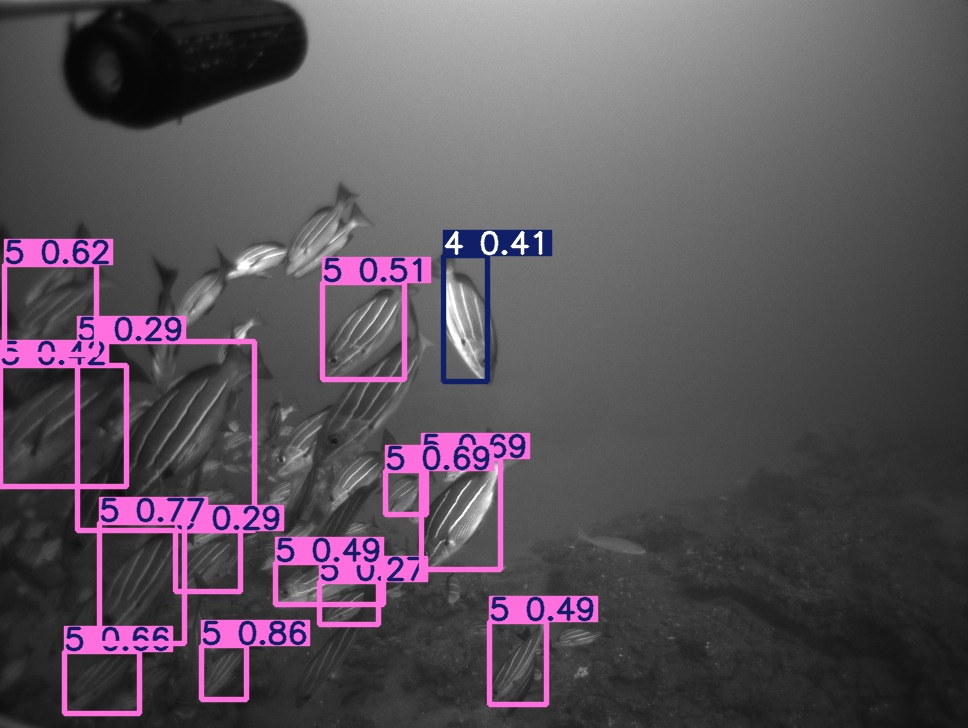

In [20]:
prediction.save('pickles.jpg')
from IPython.display import Image
Image(filename='pickles.jpg') 